# single differential $CC1p$ cross-section from begining to end

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [2]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
print "%d"%len(OverlaySamples['cosmic'])+' cosmic pairs and %d'%len(OverlaySamples['1mu-1p'])+' mu-p pairs in overlay'
cuts_order  = ['no cut','Chi2Proton','Nflashes','MatchedFlash','length','non-collinearity','vertex activity'
               ,'delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples,cuts_order=cuts_order)
print 'done'

285009 ccqe candidate pairs, 180070 in FV
74387 are 1mu-1p, 41.3%
55226 are other pairs, 30.7%
155396 are cosmic, 86.3%
--------------------------------------------------------------
36843 are CC1p0pi, 20.5%
--------------------------------------------------------------
40729 are CC1p, 22.6%
I finished loading overlay samples. We have in total 285009 pairs
155396 cosmic pairs and 74387 mu-p pairs in overlay
done


In [4]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
8211 selected CC1p events overlay


## divide into 6 dimentions: 
$\vec{p} _{\mu}$
and 
$\vec{p} _{p}$

In [32]:

Limits=dict({
            'Pmu':(0.2,1.4)
            ,'cos(theta(mu))':(-0.5,0.95)
            ,'phi(mu)':(-180,180)
            ,'Pp':(0.3,1.0)
            ,'cos(theta(p))':(0.25,0.9)
            ,'phi(p)':(-180,180)
            })
NBins=5
Bins = dict()
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins)



In [58]:
def get_sam_in_bin(sam
                   ,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,Pmu_phi_min,Pmu_phi_max
                   ,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,Pp_phi_min,Pp_phi_max):
    return sam[ (Pmu_min<sam['reco_Pmu_mcs'])
                                             &(sam['reco_Pmu_mcs']<Pmu_max)
                                             &(Pmu_cos_theta_min<sam['reco_Pmu_cos_theta'])
                                             &(sam['reco_Pmu_cos_theta']<Pmu_cos_theta_max)
                                             &(Pmu_phi_min<180./np.pi*sam['reco_Pmu_mcs_phi'])
                                             &(180./np.pi*sam['reco_Pmu_mcs_phi']<Pmu_phi_max)
                                             
                                             &(Pp_min<sam['reco_Pp'])
                                             &(sam['reco_Pp']<Pp_max)
                                             &(Pp_cos_theta_min<sam['reco_Pp_cos_theta'])
                                             &(sam['reco_Pp_cos_theta']<Pp_cos_theta_max)
                                             &(Pp_phi_min<180./np.pi*sam['reco_Pp_phi'])
                                             &(180./np.pi*sam['reco_Pp_phi']<Pp_phi_max)
                                            ]


def create_table_of_events_in_bins(sam_data=None,sam_mc_detector_cuts=None,sam_mc_all_cuts=None):
    Ndata_in_bin_array,Nmc_detector_cuts_in_bin_array,Nmc_all_cuts_in_bin_array = [],[],[]
    for i_Pmu in range(len(Bins['Pmu'][:-1])):
        Pmu_min,Pmu_max = Bins['Pmu'][i_Pmu],Bins['Pmu'][i_Pmu+1]
        
        for i_Pmu_cos_theta in range(len(Bins['cos(theta(mu))'][:-1])):
            Pmu_cos_theta_min,Pmu_cos_theta_max = Bins['cos(theta(mu))'][i_Pmu_cos_theta],Bins['cos(theta(mu))'][i_Pmu_cos_theta+1]

            for i_Pmu_phi in range(len(Bins['phi(mu)'][:-1])):
                Pmu_phi_min,Pmu_phi_max = Bins['phi(mu)'][i_Pmu_phi],Bins['phi(mu)'][i_Pmu_phi+1]
                
                for i_Pp in range(len(Bins['Pp'][:-1])):
                    Pp_min,Pp_max = Bins['Pp'][i_Pp],Bins['Pp'][i_Pp+1]

                    for i_Pp_cos_theta in range(len(Bins['cos(theta(p))'][:-1])):
                        Pp_cos_theta_min,Pp_cos_theta_max = Bins['cos(theta(p))'][i_Pp_cos_theta],Bins['cos(theta(p))'][i_Pp_cos_theta+1]

                        for i_Pp_phi in range(len(Bins['phi(p)'][:-1])):
                            Pp_phi_min,Pp_phi_max = Bins['phi(p)'][i_Pp_phi],Bins['phi(p)'][i_Pp_phi+1]
                            
                            
                            data_in_bin = get_sam_in_bin(sam_data
                                                             ,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,Pmu_phi_min,Pmu_phi_max
                                                             ,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,Pp_phi_min,Pp_phi_max)
                            mc_detector_cuts_in_bin = get_sam_in_bin(sam_mc_detector_cuts
                                                             ,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,Pmu_phi_min,Pmu_phi_max
                                                             ,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,Pp_phi_min,Pp_phi_max)

                            mc_all_cuts = get_sam_in_bin(sam_mc_all_cuts
                                                             ,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,Pmu_phi_min,Pmu_phi_max
                                                             ,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,Pp_phi_min,Pp_phi_max)

                            if len(data_in_bin)>0:
                                Ndata_in_bin_array.append(len(data_in_bin))
                                Nmc_detector_cuts_in_bin_array.append(len(mc_detector_cuts_in_bin))
                                Nmc_all_cuts_in_bin_array.append(len(mc_all_cuts))
    print 'done.'
    return np.array(Ndata_in_bin_array),np.array(Nmc_detector_cuts_in_bin_array),np.array(Nmc_all_cuts_in_bin_array)

In [59]:
Ndata_in_bin_array,Nmc_detector_cuts_in_bin_array,Nmc_all_cuts_in_bin_array = create_table_of_events_in_bins(sam_data=selected_beam_on
                                                                                                             ,sam_mc_detector_cuts=reducedOverlay['vertex activity']['CC1p']
                                                                                                             ,sam_mc_all_cuts=selected_CC1p)

done.


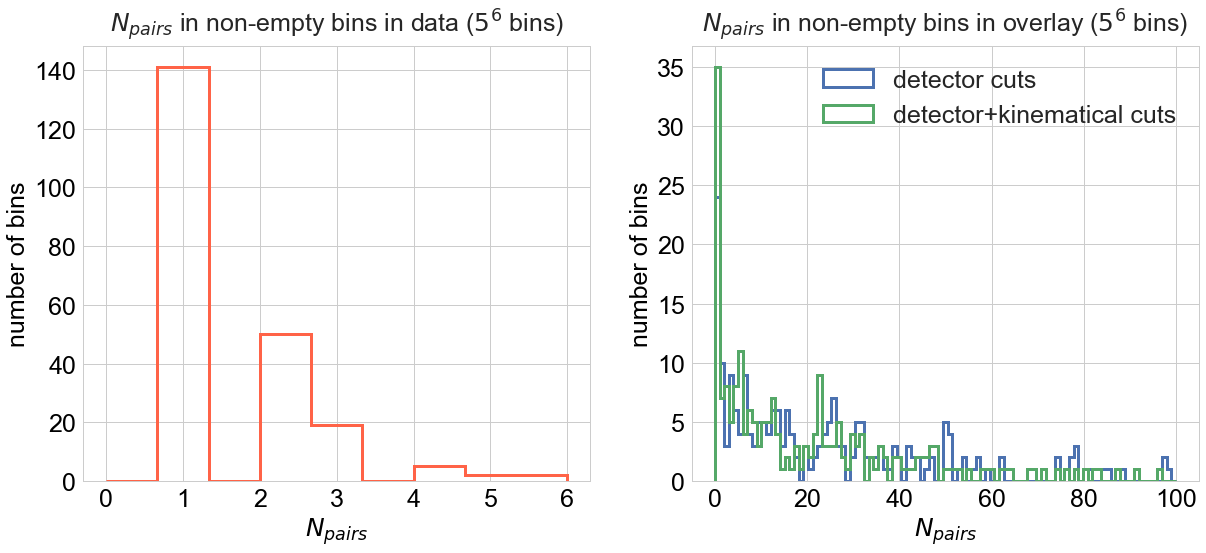

In [65]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(1,2,1)
N_selected_beam_on = N_selected_beam_on[N_selected_beam_on>0]
plt.hist(Ndata_in_bin_array,bins=linspace(0,np.max(N_selected_beam_on),10),histtype='step',linewidth=3,color=Colors['beam on']);
set_axes(ax,r'$N_{pairs}$','number of bins',do_add_legend=True,title=r'$N_{pairs}$ in non-empty bins in data ($5^6$ bins)')

ax=fig.add_subplot(1,2,2)
N_selected_CC1p = N_selected_CC1p[N_selected_CC1p>0]
plt.hist(Nmc_detector_cuts_in_bin_array,bins=linspace(0,100,100),label='detector cuts',histtype='step',linewidth=3);
# N_selected_CC1p_detector_cuts=N_selected_CC1p_detector_cuts[N_selected_CC1p_detector_cuts>0]
plt.hist(Nmc_all_cuts_in_bin_array,bins=linspace(0,100,100),label='detector+kinematical cuts',histtype='step',linewidth=3);
set_axes(ax,r'$N_{pairs}$','number of bins',do_add_legend=True,title=r'$N_{pairs}$ in non-empty bins in overlay ($5^6$ bins)')

plt.savefig('/Users/erezcohen/Desktop/Npairs_in_6d_bins.pdf')

In [64]:
N_under_5 = Nmc_all_cuts_in_bin_array[Nmc_all_cuts_in_bin_array<5]
print len(N_under_5)
print len(Nmc_all_cuts_in_bin_array)
print np.mean(Nmc_all_cuts_in_bin_array)
print len(Ndata_in_bin_array)

55
219
22.397260274
219


In [34]:
N_selected_CC1p = create_table_of_events_in_bins(sam=selected_CC1p)

done.


In [39]:
N_selected_beam_on = create_table_of_events_in_bins(sam=selected_beam_on)

done.


In [44]:
N_selected_CC1p_detector_cuts = create_table_of_events_in_bins(sam=reducedOverlay['vertex activity']['CC1p'])

done.
